In [19]:
#importer
import torch, sys, os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtik
import numpy as np
from typing import Dict
sys.path.append(os.path.abspath(".."))
from ml_utils import parse_config, activation_decode, vizualization

### CONSTANTS

In [20]:
DATASET_TRAIN_PATH = 'data/train'
DATASET_TEST_PATH  = 'data/test'
VALID_JSON = {
    "type":"object",
    "properties":
    {
        "nn_config":
        {
            "type":"object",
            "properties":
            {
                "epochs":
                {
                    "type":"integer",
                    "minimum":10
                },
                "batch_size":
                {
                  "type":"integer",
                  "minimum":10
                },
                "act_f":
                {
                    "type":"string",
                    "enum": ["identity", "relu", "sig", "silu"]
                },
                "learning_rate":
                {
                    "type":"number",
                    "minimum": 0.0,
                    "maximum":1.0
                },
                "hidden_arr":
                {
                    "type":"array",
                    "items":
                    {
                        "type":"array",
                        "minItems":2,
                        "maxItems":2,
                        "items":
                        {
                            "type":"integer"
                        }
                    }
                }
            },
            "required":["epochs", "batch_size", "act_f", "learning_rate", "hidden_arr"]
        },
        "image":
        {
            "type":"object",
            "properties":
            {
                "w":
                {
                    "type":"integer",
                    "minimum":1
                },
                "h":
                {
                    "type":"integer",
                    "minimum":1
                },
                "path":
                {
                    "type":"string"
                }
            },
            "required":["w", "h", "path"]
        }
    },
    "required":["nn_config","image"]
}

### Prepare data for learning

In [21]:

def prepare_learn_data(config:Dict)->DataLoader:
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.1307), (0.3081))]
    )#(0.1307), (0.3081)
    train_loader = DataLoader(
        dataset=datasets.MNIST(root=DATASET_TRAIN_PATH, train=True, transform=transform, download=True),
        batch_size=config['nn_config']['batch_size'], 
        shuffle=True,
        num_workers=4)
    test_loader = DataLoader(
        dataset=datasets.MNIST(root=DATASET_TEST_PATH, train=False, transform=transform, download=True),
        batch_size=config['nn_config']['batch_size'],
        shuffle=False,
        num_workers=4)
    return train_loader, test_loader 

### Model

In [22]:
from typing import List, Tuple

class NeuralNetwork(nn.Module):
    def __init__(self, hidden_arr:List[Tuple[int, int]], act_f:str) -> None:
        super().__init__()
        self._HIDDEN_ARR = hidden_arr
        self._activation = activation_decode(act_f)
        self._body = self._generate_architecture()
    
    def _generate_architecture(self)->nn.ModuleList:
        hidden = nn.ModuleList()
        for hidden_layer in self._HIDDEN_ARR:
           hidden.append(nn.Linear(hidden_layer[0], hidden_layer[1]))
        return hidden

    def forward(self, x):
        x = x.view(-1, self._HIDDEN_ARR[0][0])  # Flatten the input
        l = len(self._body)-1
        for i, layer in enumerate(self._body):
            x = layer(x)
            if i != l:
                x = self._activation(x)
        return x

### Learning process

In [23]:
def train(device:torch.device, model:NeuralNetwork, config:Dict, train_loader:DataLoader, criterion:nn.CrossEntropyLoss, optimizer:optim.Adam):
    model.train()
    x_epoch = np.arange(0, config['nn_config']['epochs'])
    y_loss = np.zeros(config['nn_config']['epochs'], dtype=float)
    
    for epoch in range(config['nn_config']['epochs']):
        running_loss = 0.0
        loss = None
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device) 
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        y_loss[epoch] = running_loss/len(train_loader)
        print(f'Epoch {epoch+1} finished with avg loss: {running_loss/len(train_loader):.4f}')
    
    vizualization(x_epoch, 'epochs', y_loss, 'loss', 'loss over epochs')

def test(device: torch.device, model:NeuralNetwork, test_loader:DataLoader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Accuracy on test set: {accuracy:.2f}%')

def learning(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = prepare_learn_data(config)
    model = NeuralNetwork(config['nn_config']['hidden_arr'], config['nn_config']['act_f']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['nn_config']['learning_rate'])
    train(device, model, config, train_loader, criterion, optimizer)
    test(device, model, test_loader)

### Test 1

Epoch 1 finished with avg loss: 0.2414
Epoch 2 finished with avg loss: 0.1001
Epoch 3 finished with avg loss: 0.0673
Epoch 4 finished with avg loss: 0.0536
Epoch 5 finished with avg loss: 0.0424
Epoch 6 finished with avg loss: 0.0356
Epoch 7 finished with avg loss: 0.0284
Epoch 8 finished with avg loss: 0.0250
Epoch 9 finished with avg loss: 0.0234
Epoch 10 finished with avg loss: 0.0224


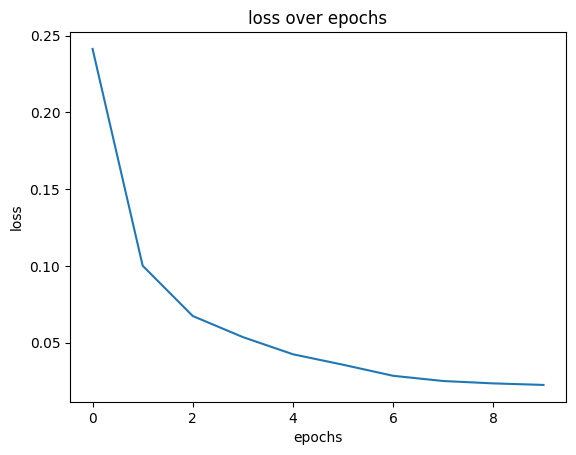

Accuracy on test set: 97.73%


In [24]:
config = parse_config('config/config1.json', VALID_JSON)
learning(config)

### Test 2
Use more deeper structure with decrise inputs cnt

Epoch 1 finished with avg loss: 0.2129
Epoch 2 finished with avg loss: 0.0876
Epoch 3 finished with avg loss: 0.0595
Epoch 4 finished with avg loss: 0.0462
Epoch 5 finished with avg loss: 0.0370
Epoch 6 finished with avg loss: 0.0314
Epoch 7 finished with avg loss: 0.0267
Epoch 8 finished with avg loss: 0.0265
Epoch 9 finished with avg loss: 0.0233
Epoch 10 finished with avg loss: 0.0193


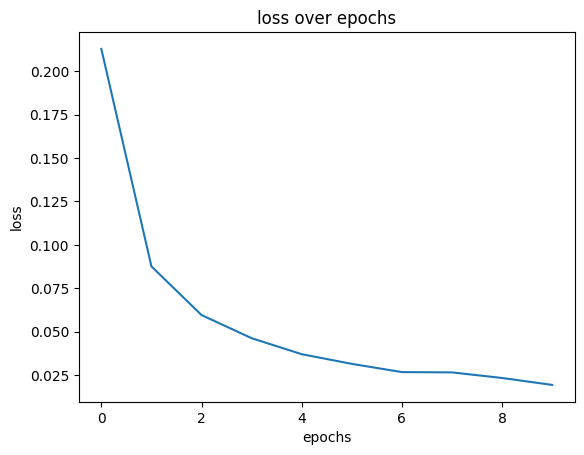

Accuracy on test set: 97.86%


In [25]:
config = parse_config('config/config2.json', VALID_JSON)
learning(config)

### Test 3
Activation function is sig

Epoch 1 finished with avg loss: 0.2441
Epoch 2 finished with avg loss: 0.1007
Epoch 3 finished with avg loss: 0.0713
Epoch 4 finished with avg loss: 0.0511
Epoch 5 finished with avg loss: 0.0421
Epoch 6 finished with avg loss: 0.0320
Epoch 7 finished with avg loss: 0.0295
Epoch 8 finished with avg loss: 0.0252
Epoch 9 finished with avg loss: 0.0221
Epoch 10 finished with avg loss: 0.0185


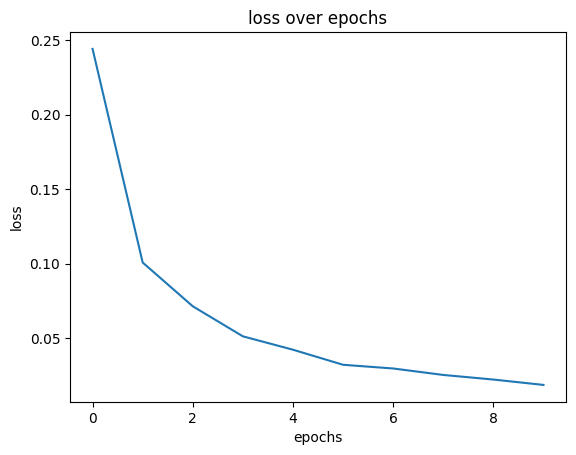

Accuracy on test set: 97.76%


In [26]:
config = parse_config('config/config3.json', VALID_JSON)
learning(config)

### Test 4
Activation function is identity

Epoch 1 finished with avg loss: 0.3781
Epoch 2 finished with avg loss: 0.3209
Epoch 3 finished with avg loss: 0.3095
Epoch 4 finished with avg loss: 0.3024
Epoch 5 finished with avg loss: 0.3001
Epoch 6 finished with avg loss: 0.2929
Epoch 7 finished with avg loss: 0.2900
Epoch 8 finished with avg loss: 0.2860
Epoch 9 finished with avg loss: 0.2844
Epoch 10 finished with avg loss: 0.2792


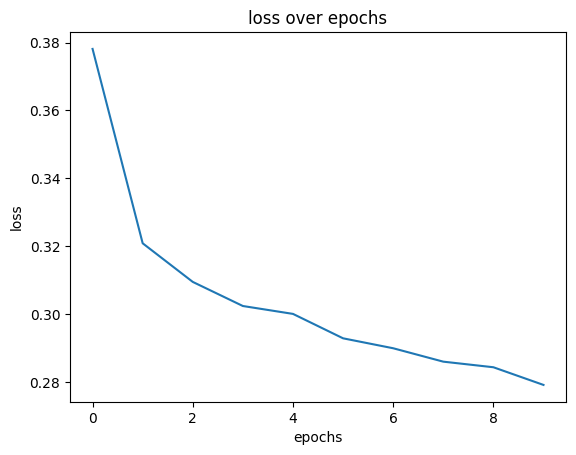

Accuracy on test set: 91.62%


In [27]:
config = parse_config('config/config4.json', VALID_JSON)
learning(config)

### Test 5
Use greater learning rate

In [28]:
config = parse_config('config/config5.json', VALID_JSON)
learning(config)

Epoch 1 finished with avg loss: 0.2925


KeyboardInterrupt: 

### Test 6
Use smaller learning rate

Epoch 1 finished with avg loss: 0.5818
Epoch 2 finished with avg loss: 0.2539
Epoch 3 finished with avg loss: 0.1994
Epoch 4 finished with avg loss: 0.1653
Epoch 5 finished with avg loss: 0.1411
Epoch 6 finished with avg loss: 0.1217
Epoch 7 finished with avg loss: 0.1071
Epoch 8 finished with avg loss: 0.0950
Epoch 9 finished with avg loss: 0.0853
Epoch 10 finished with avg loss: 0.0764


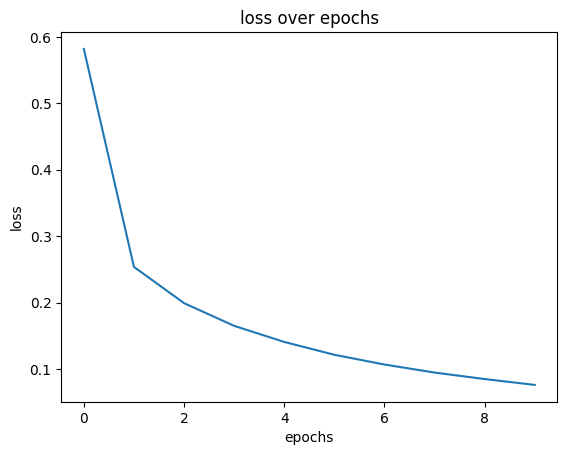

Accuracy on test set: 97.43%


In [11]:
config = parse_config('config/config6.json', VALID_JSON)
learning(config)

### Test 7
Use smaller batches

Epoch 1 finished with avg loss: 0.2265
Epoch 2 finished with avg loss: 0.1002
Epoch 3 finished with avg loss: 0.0739
Epoch 4 finished with avg loss: 0.0574
Epoch 5 finished with avg loss: 0.0467
Epoch 6 finished with avg loss: 0.0416
Epoch 7 finished with avg loss: 0.0359
Epoch 8 finished with avg loss: 0.0309
Epoch 9 finished with avg loss: 0.0272
Epoch 10 finished with avg loss: 0.0270


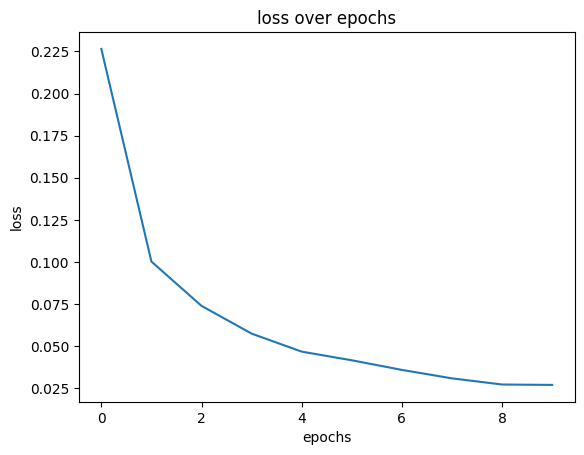

Accuracy on test set: 97.86%


In [12]:
config = parse_config('config/config7.json', VALID_JSON)
learning(config)

### Test 8
Use greater batches

Epoch 1 finished with avg loss: 0.3047
Epoch 2 finished with avg loss: 0.1231
Epoch 3 finished with avg loss: 0.0833
Epoch 4 finished with avg loss: 0.0649
Epoch 5 finished with avg loss: 0.0505
Epoch 6 finished with avg loss: 0.0408
Epoch 7 finished with avg loss: 0.0338
Epoch 8 finished with avg loss: 0.0298
Epoch 9 finished with avg loss: 0.0230
Epoch 10 finished with avg loss: 0.0217


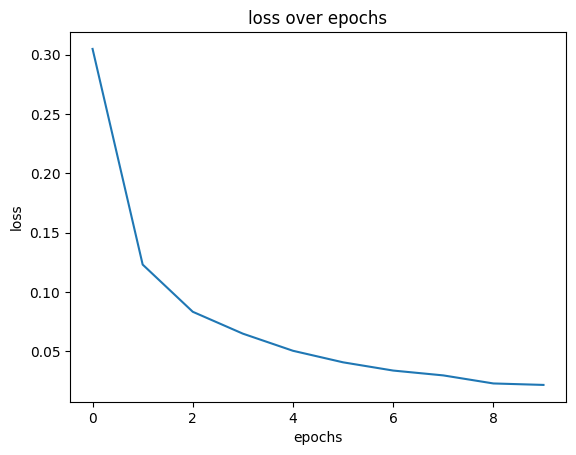

Accuracy on test set: 97.73%


In [13]:
config = parse_config('config/config8.json', VALID_JSON)
learning(config)

### Test 9
Use more epochs

In [14]:
#config = parse_config('config/config9.json', VALID_JSON)
#learning(config)
# need time